# Machine learning to predict new crescent moon visibility

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING IMPORTS
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

## Options and setup

In [2]:
#METHOD = False # replace seen column with method seen column
MULTI_OUTPUT_METHOD = False #Replace naked eye seen column with array of methods
MULTI_LABEL_METHOD = False #Replace naked eye seen column with either seen, visual aid or not seen
XGBOOST = True #Use xgboost forest or random forest
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy
LINUX = True #Use linux file paths
USE_GPU = True #Use a GPU

TITLE = f"{'XGBoost' if XGBOOST else 'Random Forest'} {'Eye' if not MULTI_LABEL_METHOD and not MULTI_OUTPUT_METHOD else ''}{'Multi-label' if MULTI_LABEL_METHOD else ''}{'Multi-output' if MULTI_OUTPUT_METHOD else ''} visibility"

## Hyperparameters

In [3]:
if XGBOOST:
    if MULTI_OUTPUT_METHOD:
        PARAMS = {'learning_rate': 0.1733, 'max_depth': 6, 'n_estimators': 50}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'learning_rate': 0.4183, 'max_depth': 2, 'n_estimators': 100}
    else:
         PARAMS = {'learning_rate': 0.55, 'max_depth': 3, 'n_estimators': 110}
         
else: #Random forest
    if MULTI_OUTPUT_METHOD:
        PARAMS = {}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
    else:
         PARAMS = {'max_depth': 12, 'n_estimators': 150}

## Reading in data

In [4]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
yallop_data_file = '..\\Data\\Data/yallop_sighting_data_with_params.csv'

if LINUX:
    icouk_data_file = '../Data/icouk_sighting_data_with_params.csv'
    icop_data_file = '../Data/icop_ahmed_2020_sighting_data_with_params.csv'
    alrefay_data_file = '../Data/alrefay_2018_sighting_data_with_params.csv'
    allawi_data_file = '../Data/schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
    yallop_data_file = '../Data/yallop_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)
yallop_data = pd.read_csv(yallop_data_file)


data = pd.concat([icouk_data,icop_data,alrefay_data,yallop_data])

print(f"Loaded {data.shape[0]} rows")

#Drop index, dependent parameters (q value etc) and visibility scale
data = data.drop(["Index","q","W","q'","W'","Visibility","Source"], axis = 1)

if MULTI_OUTPUT_METHOD:
    data = data.drop(["Seen", "Method"], axis = 1) # replaced by methods column

    ptype = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd","Not_seen"]

elif MULTI_LABEL_METHOD:
    data = data.drop(["Seen", "Methods"], axis = 1) # replaced by method column
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    ptype = ["Seen_eye", "Seen_with_aid", "Not_seen"]

else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1) #Only use seen

    ptype = ["Seen", "Not_seen"]

if RANDOM:
    data.insert(1,"Random1",np.random.rand(data.shape[0],1))
    data.insert(2,"Random2",np.random.rand(data.shape[0],1))
    data = data[['Seen', "Random1","Random2"]]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]
    #data = data[data["Cloud Level"] == 0]

print(f"Using {data.shape[0]} rows")
data.head(5)

Loaded 3555 rows
Using 3101 rows


,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Cloud Level,Seen
0,2.457309e+06,53.95763,-1.08271,0.720,2.457309e+06,2.457309e+06,21.25000,1.07310,252.63669,-2.19904,259.67487,0.00271,0.99508,7.76046,3.27214,7.03818,0.00458,54.15168,1.0,Not_seen
1,2.457339e+06,53.95763,-1.08271,0.949,2.457339e+06,2.457339e+06,51.21667,2.93009,235.97254,-3.80413,244.70058,0.00266,0.98725,11.01981,6.73422,8.72803,0.00922,55.07029,0.5,Not_seen
2,2.457398e+06,53.95763,-1.08271,0.625,2.457398e+06,2.457398e+06,59.91667,3.36351,234.01106,-4.02231,237.26745,0.00252,0.98095,8.07090,7.38583,3.25639,0.00495,58.06216,0.5,Not_seen
3,2.457428e+06,53.58333,-2.43333,1.130,2.457428e+06,2.457428e+06,88.48333,5.96340,246.17414,-6.30098,253.74311,0.00244,0.98427,14.40433,12.26438,7.56896,0.01572,59.64383,1.0,Not_seen
4,2.457428e+06,52.63860,-1.13169,1.128,2.457428e+06,2.457428e+06,87.06667,6.02324,246.74294,-6.34866,254.06088,0.00244,0.98427,14.36689,12.37190,7.31794,0.01564,59.63664,0.0,Seen


## Visualising variables

In [5]:
# Visualising a couple of variables.
variable_list =  data.columns.tolist()
print(variable_list)

# Plot data
showpairplot = False
if showpairplot == True:
   fig = sns.pairplot(data[variable_list], hue = 'Seen', palette = 'bright')

   # Change location of legend
   fig._legend.set_bbox_to_anchor((1.05, 0.5))

   # Add legend
   for t, l in zip(fig._legend.texts, ptype):
      t.set_text(str(t.get_text()) + " - " + str(l))

   plt.show()


['Date', 'Latitude', 'Longitude', 'Moon Age', 'Sunset', 'Moonset', 'Lag', 'Moon Alt', 'Moon Az', 'Sun Alt', 'Sun Az', 'Moon-Earth Dist', 'Sun-Moon Dist', 'ARCL', 'ARCV', 'DAZ', 'Illumination', 'Parallax', 'Cloud Level', 'Seen']


## ML Training

In [6]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list


if MULTI_OUTPUT_METHOD:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Methods')
    # test = pd.DataFrame(y, columns=mlb.classes_)
    # print(test.head(10))

elif MULTI_LABEL_METHOD:
    data["Method"] = data["Method"].replace("Seen_eye",2) #XGboost needs 1 and 0
    data["Method"] = data["Method"].replace("Seen_with_aid",1)
    data["Method"] = data["Method"].replace("Not_seen",0)
    y = np.array(data['Method'])
    features.remove('Method')
    
else:
    if XGBOOST:
        data["Seen"] = data["Seen"].replace("Seen",1) #XGboost needs 1 and 0
        data["Seen"] = data["Seen"].replace("Not_seen", 0)
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [7]:
# Produce randomforest classifier model and fit to training data
def select_model():
    if XGBOOST:
        if MULTI_OUTPUT_METHOD:
            if USE_GPU:
                method = "gpu_hist"
            else:
                method = "hist"
            model = XGBClassifier(tree_method=method, n_jobs=-1)
        else:
            model = XGBClassifier(n_jobs=-1)
    else:
        if MULTI_OUTPUT_METHOD:
            model = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1))
        else:
            model = RandomForestClassifier(n_jobs=-1)

    model = model.set_params(**PARAMS)
    return model
model = select_model()
# Fitting takes the input and "truth" data for classification purposes
model.fit(x_train, y_train)

c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.55, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=110, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [8]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_pred = model.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",accuracy_score(y_train, y_pred))
rf_acc_train = accuracy_score(y_train, y_pred)
y_pred = model.predict(x_test)

print("Accuracy on testing dataset:", accuracy_score(y_test, y_pred))
rf_acc_test = accuracy_score(y_test, y_pred)

if MULTI_OUTPUT_METHOD:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_pred)))



Accuracy on training dataset: 0.9983870967741936
Accuracy on testing dataset: 0.927536231884058


c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

## ROC curve

In [9]:
# Get predicted class probabilities for the test set 
if MULTI_OUTPUT_METHOD:
    #y_pred_prob = rf.predict_proba(x_test)
    #roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("Not currently working")
elif MULTI_LABEL_METHOD:
    y_pred_prob = model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    print(f"ROC curve {roc_auc}")
else:
    y_pred_prob = model.predict_proba(x_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC curve {roc_auc}")

ROC curve 0.975514840446791


c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

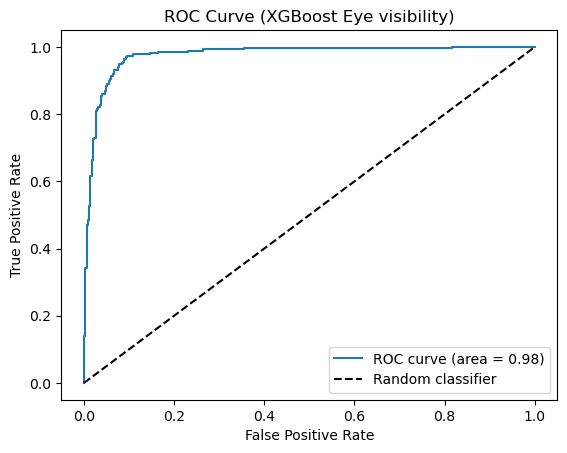

In [10]:
if MULTI_OUTPUT_METHOD:
    # roc curve for Multi classes 
    colors = ['orange','red','green','blue','purple'] 
    print("Not currently working")
else:
    # Compute the false positive rate (FPR) 
    # and true positive rate (TPR) for different classification thresholds
    if MULTI_LABEL_METHOD:
        pos = 2
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,2], pos_label=pos)
    else:
        if XGBOOST:
            pos = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=pos)
    # Plot the ROC curve 
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
    # roc curve for tpr = fpr  
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(f'ROC Curve ({TITLE})') 
    plt.legend(loc="lower right") 
    plt.show()

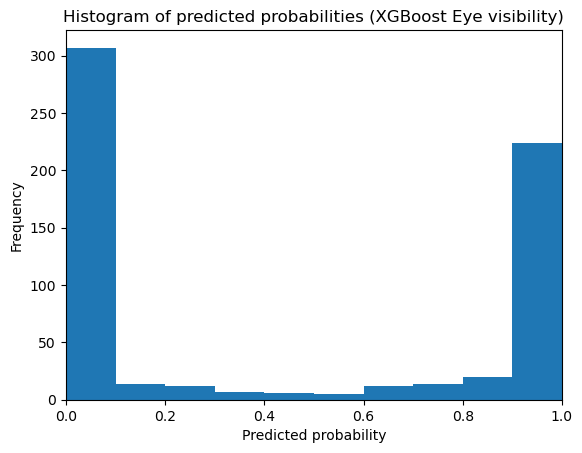

In [11]:
# Plot the predicted class probabilities 
if not MULTI_OUTPUT_METHOD:
    plt.hist(y_pred_prob, bins=10) 
    plt.xlim(0, 1) 
    plt.title(f'Histogram of predicted probabilities ({TITLE})') 
    plt.xlabel('Predicted probability') 
    plt.ylabel('Frequency') 
    plt.show() 

In [12]:
if REPEAT_ACCURACY:
    # Function to run thr random forest several times to get an average
    def random_forest(x_train, y_train, x_test, y_test, rf):
        accuracy_arr = []
        for i in range(20):
            # Fitting takes the input and "truth" data for classification purposes
            rf.fit(x_train, y_train)
            # Produce predictions for the classification of your training dataset using your model:
            y_pred = rf.predict(x_test)
            #print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred))
            accuracy_arr.append(accuracy_score(y_test, y_pred))
        
        accuracy_avg = np.mean(accuracy_arr)
        accuracy_std = np.std(accuracy_arr)
        return accuracy_avg,accuracy_std

    rf = RandomForestClassifier(n_estimators=100, criterion='gini')#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
    accuracy_val=random_forest(x_train, y_train, x_test, y_test, rf)

    print(r"When run 20 times the accuracy is {:.5} \pm {:.5}:".format(accuracy_val[0],accuracy_val[1]))

In [13]:
print('Oob Score: ', model.score(x_test, y_test))

Oob Score:  0.927536231884058


c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\miniconda3\envs\mphys-moon\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

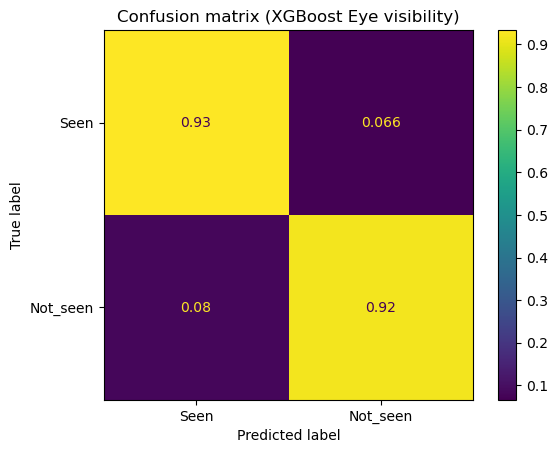

In [14]:
# plot your confusion matrix
if MULTI_OUTPUT_METHOD:
    cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_pred),normalize = 'true')
else:
    cm = confusion_matrix(y_test, y_pred,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
disp.plot()
plt.title(f"Confusion matrix ({TITLE})")
plt.show()

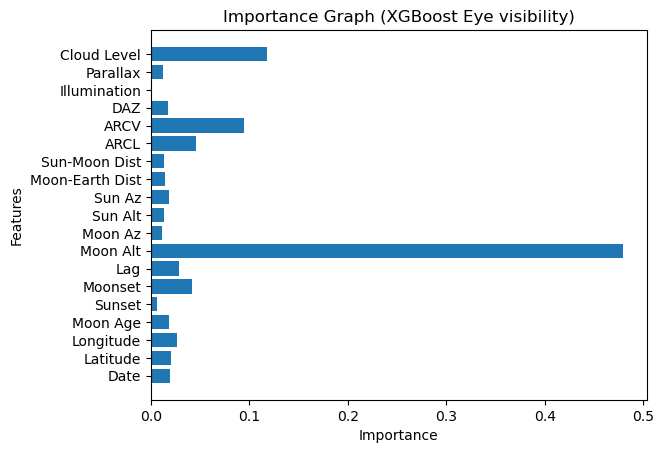

In [15]:
# Plot importance
if not XGBOOST and MULTI_OUTPUT_METHOD:
    feat_impts = [] 
    for clf in model.estimators_:
        feat_impts.append(clf.feature_importances_) 

    importance = np.mean(feat_impts, axis=0)

else:
    importance = model.feature_importances_

ytix = features
plt.barh(range(len(features)), importance)
plt.yticks(range(len(features)), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title(f"Importance Graph ({TITLE})")
plt.show()

## Hyperparameter adjustment

In [16]:
if GRID_SEARCH and not (not XGBOOST and MULTI_OUTPUT_METHOD):
    model = select_model()

    if XGBOOST:
        test_params = {
            'max_depth': np.arange(2,10,2),
            'n_estimators': [10,25,30,50,100,200],
            'learning_rate': np.linspace(0.01,0.5,7)}
            #     'max_leaf_nodes': [2,5,10,20],
    else:

        test_params = {
            'max_depth': np.arange(2,16,1),
            'n_estimators': [10,25,30,50,100,150,200]}
            #'max_features': ['sqrt', 'log2', None]}
            # 'max_leaf_nodes': [2,5,10,20],
            # 'min_samples_leaf': [2,3, 5,10],
            # 'min_samples_split': [2,3,5,10]}

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=model,
        param_grid=test_params,
         verbose=2,n_jobs=-1,
          scoring="roc_auc")

    grid_search.fit(x_train, y_train)
    #print(grid_search.best_score_)
    model_best = grid_search.best_estimator_
    print(grid_search.best_params_) 

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = model_best.predict(x_train)

    # plot the accuracies of said predictions
    model_best_acc_train = accuracy_score(y_train, y_pred_best)
    
    print(f"Accuracy on training dataset: {round(model_best_acc_train,5)}",)
    
    y_pred_best = model_best.predict(x_test)
    model_best_acc_test = accuracy_score(y_test, y_pred_best)
    print(f"Accuracy on testing dataset:{round(model_best_acc_test,5)}")
    